In [1]:
#Construct a Convlutional Neural Network to classify COVID-19 and Pneumonia using chest x-ray images
#Tensorflow as our main framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the data from the file directory containing the x-ray images of chests
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Canvas/ML/Covid19-dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Canvas/ML/Covid19-dataset/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 249 files belonging to 3 classes.
Using 200 files for training.
Found 65 files belonging to 3 classes.
Using 13 files for validation.


In [3]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
class_names = train_ds.class_names
print(class_names)
#The three classes will determine the x-ray images of chest

['Covid', 'Normal', 'Viral Pneumonia']


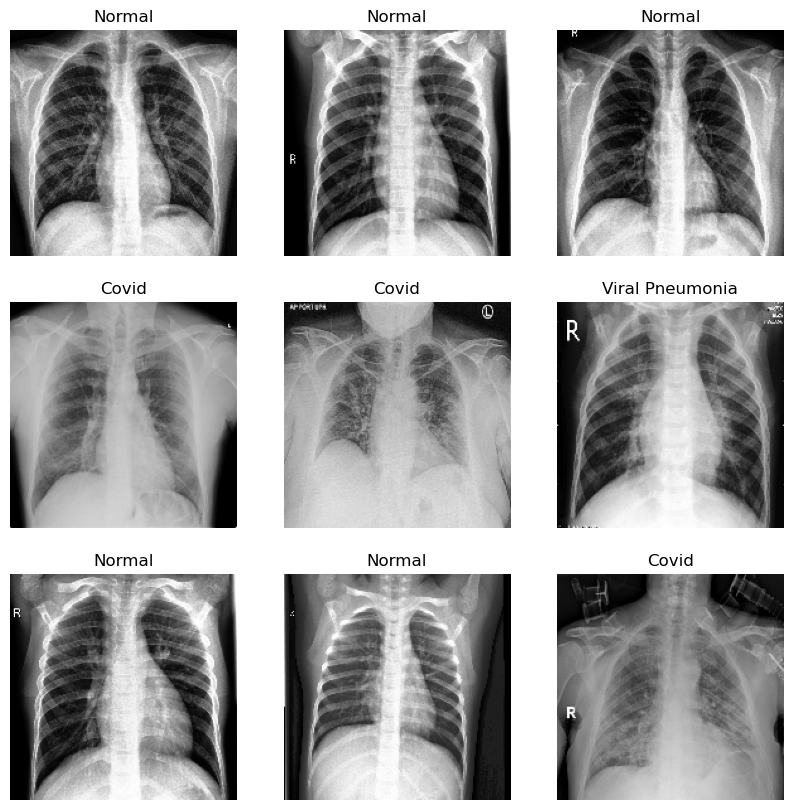

In [5]:
#Visualization of Data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
#As seen below are the example of x-ray images identifying whic class they belong
#They are the first 9 images of the dataset

In [6]:
# Image Data Augmentation
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

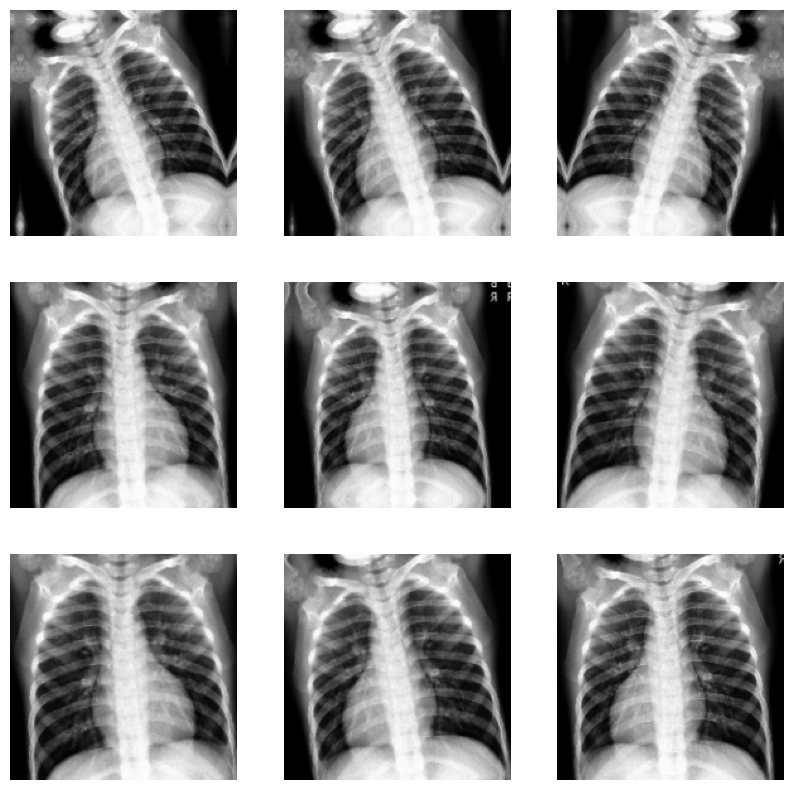

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
#Configure the dataset for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


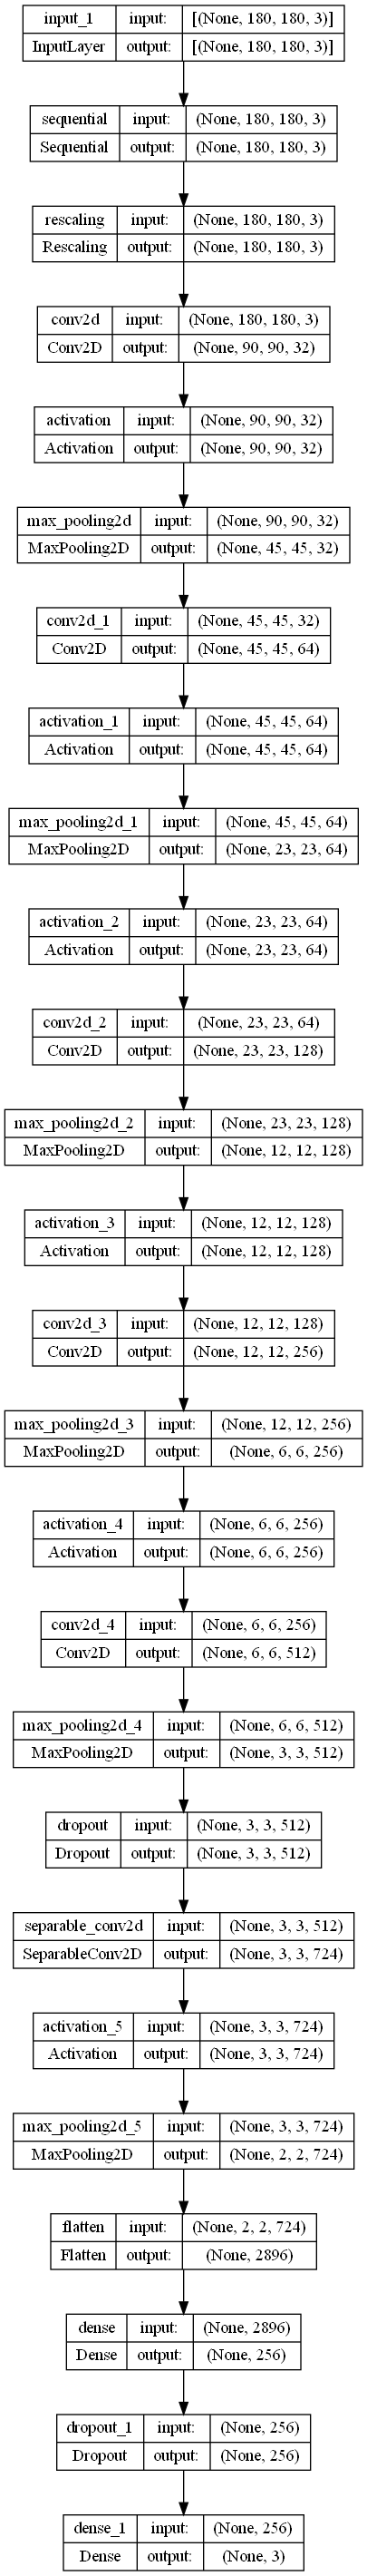

In [9]:
#Establishing the model
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [10]:
#Definition of Callbacks
def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
#Training of Model
epochs = 50

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = val_ds)

Epoch 1/50
7/7 [==============================] - 19s 1s/step - loss: 1.3833 - accuracy: 0.3650 - val_loss: 1.0980 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - 10s 1s/step - loss: 1.0976 - accuracy: 0.3200 - val_loss: 1.0958 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - 10s 1s/step - loss: 1.0953 - accuracy: 0.4450 - val_loss: 1.0938 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/50
7/7 [==============================] - 10s 1s/step - loss: 1.0909 - accuracy: 0.4450 - val_loss: 1.0861 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 5/50
7/7 [==============================] - 9s 1s/step - loss: 1.0874 - accuracy: 0.4700 - val_loss: 1.0887 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 1.1050 - accuracy: 0.3400 - val_loss: 1.0892 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 7/50
7/7 [==============================] - 10s 1s/step - loss: 1.0809 - accuracy: 0.4450 

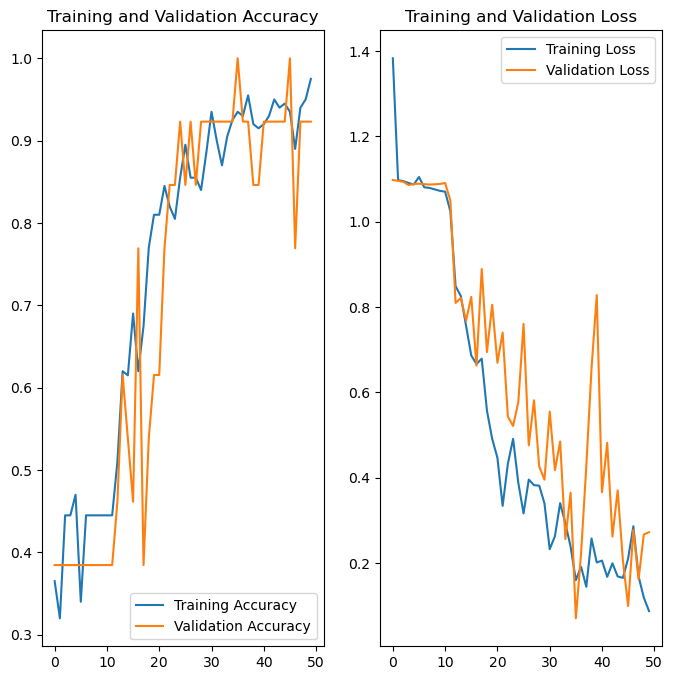

In [12]:
#Accuracy Visualization
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#The plot shows the performance on both the training and validation sets

In [13]:
#Testing of the model
#Classification Test
import cv2
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
#Importing image that will be used for testing
image_path = "D:/Canvas/ML/Covid19-dataset/validation/pic1.jpeg"
image_path2 = "D:/Canvas/ML/Covid19-dataset/validation/pic2.jpeg"
image_path3 = "D:/Canvas/ML/Covid19-dataset/validation/pic3.jpeg"
image_path4 = "D:/Canvas/ML/Covid19-dataset/validation/pic4.jpeg"
image_path5 = "D:/Canvas/ML/Covid19-dataset/validation/pic5.jpeg"
image_path6 = "D:/Canvas/ML/Covid19-dataset/validation/pic6.jpeg"
image_path7 = "D:/Canvas/ML/Covid19-dataset/validation/pic7.jpg"
image_path8 = "D:/Canvas/ML/Covid19-dataset/validation/pic8.jpeg"
image_path9 = "D:/Canvas/ML/Covid19-dataset/validation/pic9.jpeg"
image_path10 = "D:/Canvas/ML/Covid19-dataset/validation/pic10.jpeg"
merged_path = [image_path,image_path2,image_path3,image_path4,image_path5,image_path6,image_path7,image_path8,image_path9,image_path10]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
# Percent confidence determines the certainty of the model to its classification
    print(
        "This image most likely belongs to {} classification."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))
#As seen below is how it classifies the image and how certain is the model

1/1 [==============================] - 0s 267ms/step
This image most likely belongs to Normal classification.
1/1 [==============================] - 0s 42ms/step
This image most likely belongs to Normal classification.
1/1 [==============================] - 0s 41ms/step
This image most likely belongs to Viral Pneumonia classification.
1/1 [==============================] - 0s 49ms/step
This image most likely belongs to Viral Pneumonia classification.
1/1 [==============================] - 0s 40ms/step
This image most likely belongs to Normal classification.
1/1 [==============================] - 0s 40ms/step
This image most likely belongs to Covid classification.
1/1 [==============================] - 0s 37ms/step
This image most likely belongs to Covid classification.
1/1 [==============================] - 0s 52ms/step
This image most likely belongs to Viral Pneumonia classification.
1/1 [==============================] - 0s 55ms/step
This image most likely belongs to Covid classifica